# **Preparing Dependancies**

In [ ]:
!pip install diffusers==0.26.0

import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, DPMSolverMultistepScheduler
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*Flax classes are deprecated.*")

# **Kriteria 1: Melakukan Image Generation dari Teks (Text-to-Image)**

## **Load Base Pipeline Model**

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# 1. Tentukan Model ID (menggunakan v1-5 sebagai standar submission)
model_id = "runwayml/stable-diffusion-v1-5"

# 2. Load Pipeline dengan konfigurasi float16 agar lebih ringan di VRAM GPU
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
)

# 3. Pindahkan model ke GPU (CUDA)
pipe = pipe.to("cuda")

## **Generate Image**


  0%|          | 0/50 [00:00<?, ?it/s]

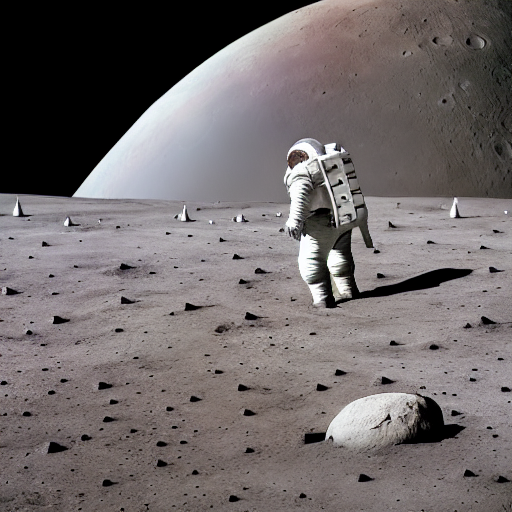

In [3]:
# Definisi helper karena file logic.py tidak ada
class LogicHelper:
    def generate_simple_image(self, pipe, prompt, negative_prompt=None, seed=None):
        generator = torch.Generator(device=pipe.device).manual_seed(seed) if seed is not None else None
        output = pipe(prompt=prompt, negative_prompt=negative_prompt, generator=generator)
        return output.images

logic = LogicHelper()

# Parameter gambar
prompt = "an astronaut on the moon with planet earth visible in the background, highly detailed, realistic, 8k resolution"
negative_prompt = "blurry, low quality, distorted"
seed = 222

# Generate
image = logic.generate_simple_image(pipe, prompt, negative_prompt=negative_prompt, seed=seed)[0]
display(image)

## **Generate Image with Hyperparameter Configuration**

  0%|          | 0/50 [00:00<?, ?it/s]

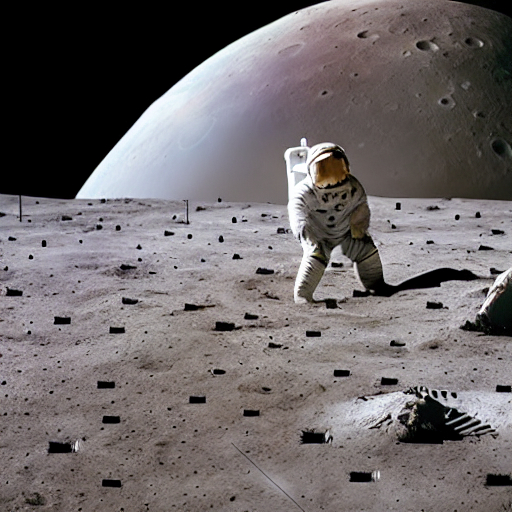

In [4]:
# Tambahkan fungsi advanced ke dalam class logic yang sudah ada
def generate_advanced_image(self, pipe, prompt, negative_prompt=None, seed=None, num_inference_steps=30, guidance_scale=7.5):
    generator = torch.Generator(device=pipe.device).manual_seed(seed) if seed is not None else None
    output = pipe(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps,
                  guidance_scale=guidance_scale, generator=generator)
    return output.images

# Tempelkan fungsi baru ke objek logic
LogicHelper.generate_advanced_image = generate_advanced_image

# Eksekusi dengan hyperparameter
image = logic.generate_advanced_image(
    pipe, prompt, negative_prompt=negative_prompt, seed=seed,
    num_inference_steps=50, guidance_scale=9.0
)[0]
display(image)

## **Guidance Scale Comparison**

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

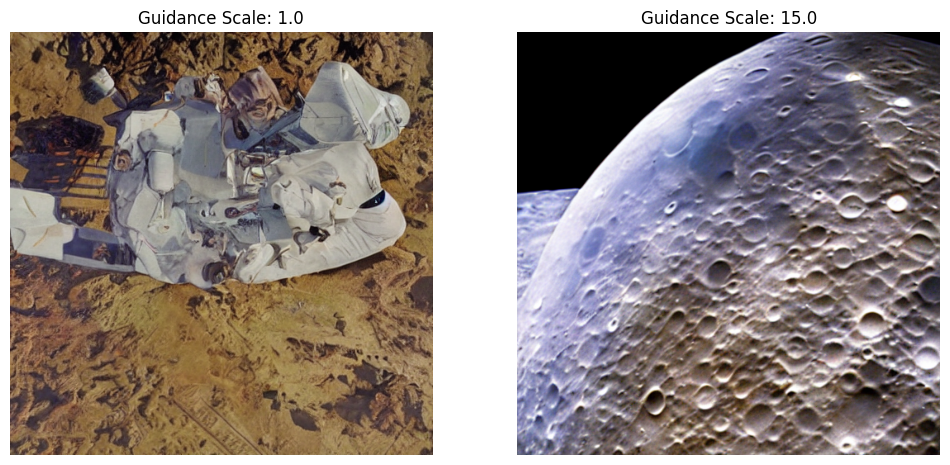

In [5]:
import matplotlib.pyplot as plt

# 1. Setting parameter
scales = [1.0, 15.0] # Membandingkan scale sangat rendah vs sangat tinggi
prompt = "an astronaut on the moon with planet earth visible in the background, highly detailed, realistic, 8k resolution"
negative_prompt = "blurry, low quality"
images_scale = []

# 2. Loop generation
for s in scales:
    # Memanggil fungsi logic helper (pastikan class LogicHelper sudah di-run di atas)
    img = logic.generate_advanced_image(
        pipe,
        prompt,
        negative_prompt=negative_prompt,
        seed=222,           # Seed harus sama untuk perbandingan yang adil
        guidance_scale=s,   # Variabel scale yang diuji
        num_inference_steps=30
    )[0]
    images_scale.append(img)

# 3. Visualisasi berdampingan
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, ax in enumerate(axes):
    ax.imshow(images_scale[i])
    ax.set_title(f"Guidance Scale: {scales[i]}")
    ax.axis('off')
plt.show()

### Guidance Scale Explanation:

*   **Gambar dengan "Scale" Rendah:**
Gambar dengan "Scale" Rendah (1.0):
Gambar tampak sangat abstrak, kurang detail, dan seringkali tidak menyerupai deskripsi astronot atau bumi dalam prompt. Karakteristik visualnya memiliki variasi yang acak dan terlihat pudar karena AI diberikan kebebasan penuh tanpa dipaksa mengikuti instruksi teks secara ketat.

*   **Gambar dengan "Scale" Tinggi:**
Gambar terlihat sangat patuh pada prompt dengan detail yang jauh lebih tegas dan tajam pada subjek astronot serta planet bumi. Perbedaannya sangat kontras dibandingkan scale rendah; warna tampak lebih jenuh (vibrant) dan garis objek lebih jelas, meskipun jika terlalu tinggi kadang warna bisa terlihat terlalu "tajam" atau sedikit terbakar (oversaturated).



## **Inference Steps Comparison**

In [ ]:
import matplotlib.pyplot as plt

# 1. Konfigurasi Experiment
steps_li = [5, 20, 50, 100]
prompt = "an astronaut on the moon with planet earth visible in the background, highly detailed, realistic, 8k resolution"
negative_prompt = "blurry, low quality"
images_steps = []

# 2. Loop Generation berdasarkan jumlah steps
for s in steps_li:
    # Menggunakan seed yang sama (222) agar perbandingan konsisten
    img = logic.generate_advanced_image(
        pipe,
        prompt,
        negative_prompt=negative_prompt,
        seed=222,
        num_inference_steps=s, # Variabel steps yang diuji
        guidance_scale=7.5
    )[0]
    images_steps.append(img)

# 3. Visualisasi Hasil
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(images_steps[i])
    ax.set_title(f"Steps: {steps_li[i]}")
    ax.axis('off')
plt.show()

### **Inference Step Explanation:**

*   **Gambar dengan "Step" Rendah:**  
*Gambar yang dihasilkan pada jumlah step rendah cenderung tampak sangat buram, kurang detail, dan seringkali masih dipenuhi oleh noise (bintik-bintik acak) atau artefak visual yang mengganggu. Hal ini terjadi karena proses denoising (pembersihan gambar) belum selesai dilakukan oleh model, sehingga struktur objek (seperti astronot) belum terbentuk secara tajam dan proporsional.*

*   **Gambar dengan "Step" Tinggi:**  
*Gambar terlihat jauh lebih tajam, jernih, dan memiliki detail yang sangat kaya pada tekstur (seperti detail pada baju astronot atau kawah bulan). Perbedaan utama dibandingkan step rendah adalah kehalusan gradasi warna, hilangnya artefak visual, serta stabilitas visual yang lebih baik karena model memiliki lebih banyak iterasi untuk menyempurnakan setiap bagian gambar hingga mencapai hasil akhir yang matang.*

## **Batch Inference from One Prompt**

In [ ]:
# 1. Tentukan parameter
prompt = "an astronaut on the moon with planet earth visible in the background, highly detailed, realistic, 8k resolution"
num_images = 3  # Jumlah gambar yang ingin dihasilkan sekaligus

# 2. Jalankan inference dengan parameter num_images_per_prompt
# Kita menggunakan 'pipe' langsung karena fungsi batch biasanya sudah bawaan pipeline
output_images = pipe(
    prompt=prompt,
    num_images_per_prompt=num_images,
    num_inference_steps=30,
    guidance_scale=7.5
).images

# 3. Tampilkan semua hasil gambar dalam satu baris
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(output_images[i])
    ax.set_title(f"Variation {i+1}")
    ax.axis('off')
plt.show()

## **Load Scheduler**

In [ ]:
from diffusers import EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler, DDIMScheduler
import matplotlib.pyplot as plt

# 1. Siapkan Parameter Dasar
prompt = "an astronaut on the moon with planet earth visible in the background, highly detailed, realistic, 8k resolution"
seed = 222
num_steps = 30
images_sched = []

# 2. Daftar Scheduler yang akan diuji
schedulers = [
    ("Euler A", EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)),
    ("DPM++", DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)),
    ("DDIM", DDIMScheduler.from_config(pipe.scheduler.config))
]

# 3. Loop Generation untuk setiap Scheduler
for name, sched in schedulers:
    # Ganti scheduler pada pipeline
    pipe.scheduler = sched

    # Generate gambar
    img = pipe(
        prompt=prompt,
        num_inference_steps=num_steps,
        guidance_scale=7.5,
        generator=torch.Generator(device=pipe.device).manual_seed(seed)
    ).images[0]

    images_sched.append(img)

# 4. Visualisasi Berdampingan
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axes):
    ax.imshow(images_sched[i])
    ax.set_title(f"Scheduler: {schedulers[i][0]}")
    ax.axis('off')
plt.show()

### **Scheduler Comparation:**

*   **Gambar dengan "Euler A Scheduler":**  
*Menghasilkan gambar dengan tekstur yang cenderung lebih lembut dan artistik. Scheduler ini bersifat ancestral, yang berarti gambar bisa terus berubah secara subtil meskipun jumlah step ditambah sangat tinggi. Biasanya memberikan hasil yang bagus dalam waktu singkat (step rendah).*

*   **Gambar dengan "DPM++ Scheduler":**  
*Dikenal sebagai salah satu scheduler tercepat dan paling efisien saat ini. Gambar yang dihasilkan biasanya memiliki detail yang sangat tajam dan konvergen (stabil) lebih cepat daripada Euler A, sehingga sering menjadi pilihan utama untuk kualitas fotorealistik.*

*   **Gambar dengan "DDIM Scheduler":**  
*Merupakan scheduler klasik yang bersifat deterministik. Keunggulannya adalah stabilitas tinggi dan kemampuannya untuk melakukan inversion (penting untuk teknik editing gambar tingkat lanjut). Hasilnya cenderung konsisten namun terkadang membutuhkan lebih banyak step untuk menyamai ketajaman DPM++.*

# **Kriteria 2: Menyempurnakan Gambar Melalui Image-to-Image**

## **Base + Refiner Image Generation**


In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
import torch

# 1. Load Pipeline khusus Image-to-Image
# Kita bisa menggunakan model yang sama (v1-5)
pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

# 2. Siapkan Gambar Input (Gunakan gambar astronot dari langkah sebelumnya)
# Pastikan variabel 'image' dari Kriteria 1 masih ada di memori
init_image = image.convert("RGB").resize((512, 512))

# 3. Tentukan Prompt untuk Modifikasi
prompt = "A majestic astronaut in a golden suit, fantasy style, oil painting"
negative_prompt = "blurry, low quality"

# 4. Generate dengan Image-to-Image
# strength: 0.0 (gambar asli) sampai 1.0 (gambar berubah total)
refined_image = pipe_img2img(
    prompt=prompt,
    image=init_image,
    strength=0.6,
    guidance_scale=7.5,
    negative_prompt=negative_prompt
).images[0]

# 5. Tampilkan Perbandingan
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(init_image)
ax[0].set_title("Original Image")
ax[1].imshow(refined_image)
ax[1].set_title("Refined (Img2Img) Image")
for a in ax: a.axis('off')
plt.show()

## **Inpainting**

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch

# Memuat model khusus inpainting
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16
).to("cuda")

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1. Gunakan gambar hasil generate sebelumnya sebagai base (misal: variabel 'image')
# Pastikan gambar berukuran 512x512
init_image = image.convert("RGB").resize((512, 512))

# 2. Membuat Mask Hitam (0) dengan area Putih (255) untuk area yang akan diubah
# Contoh: Kita akan menutup area tengah (misal helm astronot)
mask_array = np.zeros((512, 512), dtype=np.uint8)
mask_array[150:350, 180:380] = 255  # Area kotak di tengah
mask_image = Image.fromarray(mask_array)

# Tampilkan gambar dasar dan mask-nya
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(init_image)
ax[0].set_title("Original Image")
ax[1].imshow(mask_image, cmap='gray')
ax[1].set_title("Manual Mask (White = Area to change)")
for a in ax: a.axis('off')
plt.show()

## **Inpainting Menggunakan Automasking**

### **load Model Segmentation Untuk Masking**

In [ ]:
from transformers import pipeline

# Menggunakan model segmentasi untuk mendeteksi objek secara otomatis
segmenter = pipeline("image-segmentation", model="nvidia/segformer-b0-finetuned-ade-150-512-512")

### **Masking with Segmentation Model**

In [ ]:
# 1. Deteksi semua objek dalam gambar
segments = segmenter(init_image)

# 2. Cari objek 'sky' atau 'person' untuk diubah
# Kita cari segmen yang labelnya sesuai dengan target kita
target_label = "sky"
auto_mask = None

for segment in segments:
    if segment['label'] == target_label:
        auto_mask = segment['mask']
        break

# Jika label tidak ditemukan, ambil segmen pertama saja sebagai contoh
if auto_mask is None:
    auto_mask = segments[0]['mask']

# Tampilkan mask hasil deteksi AI
plt.imshow(auto_mask, cmap='gray')
plt.title(f"Automatic Mask for: {target_label}")
plt.axis('off')
plt.show()

### **Generate**

In [ ]:
prompt = "a face of a cute cat inside the astronaut helmet, highly detailed"
negative_prompt = "blurry, distorted, ugly"

# Jalankan proses Inpainting
inpainted_result = pipe_inpaint(
    prompt=prompt,
    image=init_image,
    mask_image=mask_image,
    negative_prompt=negative_prompt,
    num_inference_steps=30
).images[0]

# Tampilkan hasil
plt.figure(figsize=(6, 6))
plt.imshow(inpainted_result)
plt.title("Manual Inpainting Result")
plt.axis('off')
plt.show()

## **Outpainting**

### **Prepare the Canvas**

In [ ]:
from PIL import Image, ImageOps

# 1. Gunakan gambar hasil generate sebelumnya (512x512)
init_image = image.convert("RGB").resize((512, 512))

# 2. Tentukan ukuran perluasan (misal menambah 256 piksel di setiap sisi)
padding = 256
new_size = (init_image.width + padding * 2, init_image.height + padding * 2)

# 3. Buat kanvas baru dengan warna rata-rata gambar asli agar transisinya halus
outpaint_canvas = Image.new("RGB", new_size, (128, 128, 128))
outpaint_canvas.paste(init_image, (padding, padding))

# 4. Buat Mask untuk area Outpainting
# Area tengah (gambar asli) berwarna Hitam, area luar (kanvas baru) berwarna Putih
outpaint_mask = Image.new("L", new_size, 255)
outpaint_mask.paste(Image.new("L", (512, 512), 0), (padding, padding))

# Tampilkan kanvas persiapan
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(outpaint_canvas)
ax[0].set_title("Prepared Canvas (Centered)")
ax[1].imshow(outpaint_mask, cmap='gray')
ax[1].set_title("Outpaint Mask (White = New Area)")
for a in ax: a.axis('off')
plt.show()

### **Generate**

In [ ]:
# Resize ke 512x512 kembali karena model SD v1-5 optimal di ukuran ini
# (Atau biarkan jika GPU kamu kuat, tapi resize disarankan untuk kestabilan)
canvas_resized = outpaint_canvas.resize((512, 512))
mask_resized = outpaint_mask.resize((512, 512))

prompt = "A vast lunar landscape with craters and stars, cinematic space environment, high resolution"

outpainted_result = pipe_inpaint(
    prompt=prompt,
    image=canvas_resized,
    mask_image=mask_resized,
    num_inference_steps=30
).images[0]

plt.figure(figsize=(8, 8))
plt.imshow(outpainted_result)
plt.title("Outpainting Result")
plt.axis('off')
plt.show()

## **Outpainting Zoom Out**

### **Prepare Canvas for Zoom Out**

In [ ]:
# 1. Perkecil gambar asli (Zoom Out)
zoom_scale = 0.5 # Kecilkan hingga 50%
smaller_image = init_image.resize((int(512 * zoom_scale), int(512 * zoom_scale)))

# 2. Buat kanvas 512x512 dan tempel gambar kecil di tengah
zoom_out_canvas = Image.new("RGB", (512, 512), (0, 0, 0))
offset = (512 - smaller_image.width) // 2
zoom_out_canvas.paste(smaller_image, (offset, offset))

# 3. Buat mask untuk area sekeliling gambar kecil
zoom_out_mask = Image.new("L", (512, 512), 255)
zoom_out_mask.paste(Image.new("L", smaller_image.size, 0), (offset, offset))

display(zoom_out_canvas)

### **Generate**

In [ ]:
prompt = "full view of an astronaut standing on the moon, planet earth in the distance, wide shot, masterpiece"

zoom_out_result = pipe_inpaint(
    prompt=prompt,
    image=zoom_out_canvas,
    mask_image=zoom_out_mask,
    num_inference_steps=30
).images[0]

display(zoom_out_result)